In [1]:
# Referência: https://nbviewer.org/gist/rsignell-usgs/35e1b44103118900d9b9d136ba2f2e9a
import numpy as np
import xarray as xr
import pandas as pd
import numcodecs
import datetime
from dask.distributed import Client, progress, LocalCluster

In [2]:
# Lista de datas de análise
dates = pd.date_range(start='2020-06-01 00:00',end='2020-06-01 00:00', freq='1D')

# Diretório onde se encontram os arquivos separados por datas de análise
bpath = '/pesq/dados/ensemble/dsk005/carlos.bastarz/xc50/oensMB09.svn/pos/dataout.exp_anl_no_topo_smooth/TQ0126L028'

# Lista de membros dos conjuntos
members = ['NMC', 
           '01P', '01N']#, 
           #'02P', '02N', 
           #'03P', '03N', 
           #'04P', '04N', 
           #'05P', '05N', 
           #'06P', '06N', 
           #'07P', '07N']

# Faz um loop entre as datas inicial e final das análises para montar a lista com os nomes de todos os arquivos a serem abertos, de análises e previsões:
date_curr = dates[0]
date_last = dates[-1]

# Dicionário com todos os arquivos a serem lidos, organizados por data de referência (ref_dates) e membros
ref_dates = {}

while date_curr <= date_last:
    #print(date_curr)
    
    # Lista temporária dos arquivos a serem lidos e adicionados ao dicionário principal
    #files = []
    files = {}
    
    # Para cada membro do conjunto, calcula as datas de previsões a partir da análise e, ao final adiciona o nome do arquivo à lista files:
    for member in members:
        files_lst = []
    
        # Para cada análise, determina as 360 horas de previsões:
        #for fct in range(0,360,6):
        for fct in range(6,360,6): # força apenas as previsões
            date_fct = date_curr
            date_fct += datetime.timedelta(hours=fct)
    
            # Define o nome dos arquivos de análises e previsões:
            if date_fct == date_curr:
                preffix = 'icn'
            else:
                preffix = 'fct'
            
            file = bpath + '/{}/'.format(date_curr.strftime('%Y%m%d%H')) + member + '/GPOS' + member + '{}{}P.'.format(date_curr.strftime('%Y%m%d%H'),date_fct.strftime('%Y%m%d%H')) + preffix + '.TQ0126L028.grb'
    
            # Adiciona o arquivo à lista:
            #files.append(file)
            files_lst.append(file)
            files[member] = files_lst
    
        # Adiciona os arquivos ao dicionário principal
        ref_dates[date_curr.strftime('%Y%m%d%H')] = files
    
    # Atualiza a data da análise
    date_curr += datetime.timedelta(days=1)

In [3]:
first_file = ref_dates['2020060100']['NMC'][0]

In [4]:
dset = xr.open_dataset(first_file, engine='pynio')

In [5]:
dset

<xarray.Dataset>
Dimensions:              (g4_lat_0: 192, g4_lon_1: 384, lv_ISBL2: 9)
Coordinates:
  * lv_ISBL2             (lv_ISBL2) int32 50 200 250 300 500 700 850 925 1000
  * g4_lat_0             (g4_lat_0) float32 89.28 88.36 87.42 ... -88.36 -89.28
  * g4_lon_1             (g4_lon_1) float32 0.0 0.9375 1.875 ... 358.1 359.1
Data variables: (12/34)
    PSNM_GDS4_MSL        (g4_lat_0, g4_lon_1) float32 ...
    ZGEO_GDS4_ISBL       (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    TEMP_GDS4_ISBL       (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    UVEL_GDS4_ISBL       (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    VVEL_GDS4_ISBL       (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    FCOR_GDS4_ISBL       (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    ...                   ...
    UVES_GDS4_SFC        (g4_lat_0, g4_lon_1) float32 ...
    USST_GDS4_SFC        (g4_lat_0, g4_lon_1) float32 ...
    VVES_GDS4_SFC        (g4_lat_0, g4_lon_1) float32 ...
    VSST_GDS4_SFC        (g4_lat_0, g4_lon_1) float32 ...
    OCIS_GDS4_SFC        (g4_lat_0, g4_lon_1) float32 ...
    UMRS_GDS4_SFC        (g4_lat_0, g4_lon_1) float32 ...

In [6]:
time_chunk_size = 1 
mem_chunk_size = 9

In [7]:
cluster = LocalCluster()
cluster

In [8]:
client = Client(cluster)

In [9]:
numcodecs.blosc.use_threads = False

In [10]:
%%time

# Faz um loop entre as datas inicial e final das análises para montar a lista com os nomes de todos os arquivos a serem abertos, de análises e previsões:
date_curr = dates[0]
date_last = dates[-1]

while date_curr <= date_last:
       
    for member in members:
    
        print(date_curr, member)
    
        # Abre todos os arquivos daquele membro e data de referência e salva em disco
        ds = xr.open_mfdataset(ref_dates[str(date_curr.strftime('%Y%m%d%H'))][member][:], 
                               parallel=True, concat_dim='time',
                               combine='nested', compat='identical',
                               decode_times=False, decode_coords=False, decode_cf=False,
                               engine='pynio')
    
        ds1 = ds.chunk(chunks={'time': 59})#, 'member': mem_chunk_size})
    
        ds1.to_zarr('/mnt/beegfs/carlos.bastarz/test_zarr2/oensMB09/' + date_curr.strftime('%Y%m%d%H') + '/' + member + '/', consolidated=True, mode='w')
    
    # Atualiza a data da análise
    date_curr += datetime.timedelta(days=1)        

2020-06-01 00:00:00 NMC


2020-06-01 00:00:00 01P


2020-06-01 00:00:00 01N


CPU times: user 14.4 s, sys: 1.47 s, total: 15.9 s
Wall time: 25.1 s


In [11]:
%%time

# Abre todos os membros de uma determinada data e atribui as coordenadas da dimensão time

ds_zarr = {}

for member in members:
    ds_zarr[member] = xr.open_zarr('/mnt/beegfs/carlos.bastarz/test_zarr2/oensMB09/2020060100/' + member, consolidated=True)
    ds_zarr[member]['time'] = pd.date_range(start=dates[0], periods=ds.sizes['time'], freq='6H')

CPU times: user 147 ms, sys: 16.4 ms, total: 164 ms
Wall time: 175 ms


In [12]:
ds_zarr

{'NMC': <xarray.Dataset>
 Dimensions:              (time: 59, g4_lat_0: 192, g4_lon_1: 384, lv_ISBL2: 9)
 Coordinates:
   * g4_lat_0             (g4_lat_0) float32 89.28 88.36 87.42 ... -88.36 -89.28
   * g4_lon_1             (g4_lon_1) float32 0.0 0.9375 1.875 ... 358.1 359.1
   * lv_ISBL2             (lv_ISBL2) int32 50 200 250 300 500 700 850 925 1000
   * time                 (time) datetime64[ns] 2020-06-01 ... 2020-06-15T12:0...
 Data variables: (12/34)
     AGPL_GDS4_EATM       (time, g4_lat_0, g4_lon_1) float32 dask.array<chunksize=(59, 192, 384), meta=np.ndarray>
     CAPE_GDS4_EATM       (time, g4_lat_0, g4_lon_1) float32 dask.array<chunksize=(59, 192, 384), meta=np.ndarray>
     CBNV_GDS4_CTL        (time, g4_lat_0, g4_lon_1) float32 dask.array<chunksize=(59, 192, 384), meta=np.ndarray>
     CINE_GDS4_EATM       (time, g4_lat_0, g4_lon_1) float32 dask.array<chunksize=(59, 192, 384), meta=np.ndarray>
     FCOR_GDS4_ISBL       (time, lv_ISBL2, g4_lat_0, g4_lon_1) float32 dask.

In [13]:
ds_zarr['NMC']

<xarray.Dataset>
Dimensions:              (time: 59, g4_lat_0: 192, g4_lon_1: 384, lv_ISBL2: 9)
Coordinates:
  * g4_lat_0             (g4_lat_0) float32 89.28 88.36 87.42 ... -88.36 -89.28
  * g4_lon_1             (g4_lon_1) float32 0.0 0.9375 1.875 ... 358.1 359.1
  * lv_ISBL2             (lv_ISBL2) int32 50 200 250 300 500 700 850 925 1000
  * time                 (time) datetime64[ns] 2020-06-01 ... 2020-06-15T12:0...
Data variables: (12/34)
    AGPL_GDS4_EATM       (time, g4_lat_0, g4_lon_1) float32 dask.array<chunksize=(59, 192, 384), meta=np.ndarray>
    CAPE_GDS4_EATM       (time, g4_lat_0, g4_lon_1) float32 dask.array<chunksize=(59, 192, 384), meta=np.ndarray>
    CBNV_GDS4_CTL        (time, g4_lat_0, g4_lon_1) float32 dask.array<chunksize=(59, 192, 384), meta=np.ndarray>
    CINE_GDS4_EATM       (time, g4_lat_0, g4_lon_1) float32 dask.array<chunksize=(59, 192, 384), meta=np.ndarray>
    FCOR_GDS4_ISBL       (time, lv_ISBL2, g4_lat_0, g4_lon_1) float32 dask.array<chunksize=(59, 9, 192, 384), meta=np.ndarray>
    LSMK_GDS4_SFC        (time, g4_lat_0, g4_lon_1) float32 dask.array<chunksize=(59, 192, 384), meta=np.ndarray>
    ...                   ...
    V10M_GDS4_HTGL       (time, g4_lat_0, g4_lon_1) float32 dask.array<chunksize=(59, 192, 384), meta=np.ndarray>
    VORT_GDS4_ISBL       (time, lv_ISBL2, g4_lat_0, g4_lon_1) float32 dask.array<chunksize=(59, 9, 192, 384), meta=np.ndarray>
    VSST_GDS4_SFC        (time, g4_lat_0, g4_lon_1) float32 dask.array<chunksize=(59, 192, 384), meta=np.ndarray>
    VVEL_GDS4_ISBL       (time, lv_ISBL2, g4_lat_0, g4_lon_1) float32 dask.array<chunksize=(59, 9, 192, 384), meta=np.ndarray>
    VVES_GDS4_SFC        (time, g4_lat_0, g4_lon_1) float32 dask.array<chunksize=(59, 192, 384), meta=np.ndarray>
    ZGEO_GDS4_ISBL       (time, lv_ISBL2, g4_lat_0, g4_lon_1) float32 dask.array<chunksize=(59, 9, 192, 384), meta=np.ndarray>

In [14]:
ds_zarr['NMC'].PREC_GDS4_SFC_acc6h

<xarray.DataArray 'PREC_GDS4_SFC_acc6h' (time: 59, g4_lat_0: 192, g4_lon_1: 384)>
dask.array<open_dataset-95da4b9846a882d85a267bf13c8103bcPREC_GDS4_SFC_acc6h, shape=(59, 192, 384), dtype=float32, chunksize=(59, 192, 384), chunktype=numpy.ndarray>
Coordinates:
  * g4_lat_0  (g4_lat_0) float32 89.28 88.36 87.42 ... -87.42 -88.36 -89.28
  * g4_lon_1  (g4_lon_1) float32 0.0 0.9375 1.875 2.813 ... 357.2 358.1 359.1
  * time      (time) datetime64[ns] 2020-06-01 ... 2020-06-15T12:00:00
Attributes:
    center:                   Brasilian Space Agency - INPE
    forecast_time:            [1]
    forecast_time_units:      6 hours
    gds_grid_type:            [4]
    initial_time:             06/01/2020 (00:00)
    level_indicator:          [1]
    long_name:                TOTAL PRECIPITATION
    parameter_number:         [61]
    parameter_table_version:  [254]
    units:                    Kg/m2/day

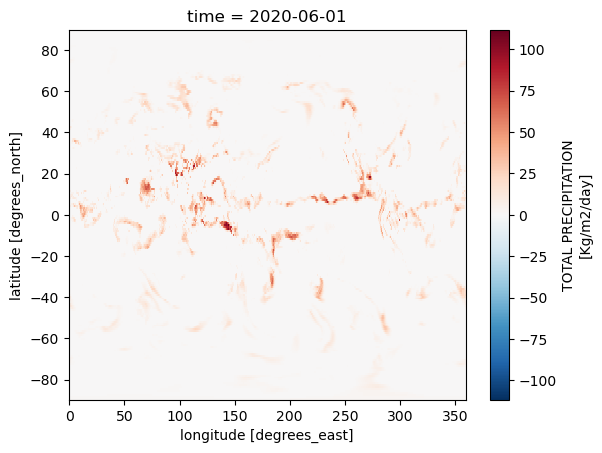

2022-11-04 13:45:04,583 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-04 13:45:04,583 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-04 13:45:04,583 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-04 13:45:04,584 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-04 13:45:04,604 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-04 13:45:04,608 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-04 13:45:04,615 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-04 13:45:04,615 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-04 13:45:04,618 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-04 13:45:04,622 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-04 13:45:04,625 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-04 13:45:04,625 - distributed.nanny

In [15]:
ds_zarr['NMC'].PREC_GDS4_SFC_acc6h.isel(time=0).plot()